In [8]:
# Importing standard Qiskit libraries
# from qiskit import QuantumCircuit, transpile
# from qiskit.visualization import *
# from ibm_quantum_widgets import *

# # qiskit-ibmq-provider has been deprecated.
# # Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# # Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")

# # Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# # result = Sampler().run(circuits).result()

In [32]:
import numpy as np
import pandas as pd

train_features=np.load('X_train.npy')
train_labels=np.load('y_train.npy')
test_features=np.load('X_test.npy')
test_labels=np.load('y_test.npy')

In [33]:
# Calculate the dimensionality of the dataset
data=np.load("X_train.npy")
dimensionality = data.shape[1]  # Number of columns represents the dimensionality
print("Dimensionality of the dataset:", dimensionality)

Dimensionality of the dataset: 128


In [34]:
from sklearn.preprocessing import MinMaxScaler

train_features= MinMaxScaler().fit_transform(train_features)
test_features= MinMaxScaler().fit_transform(test_features)

<Axes: >

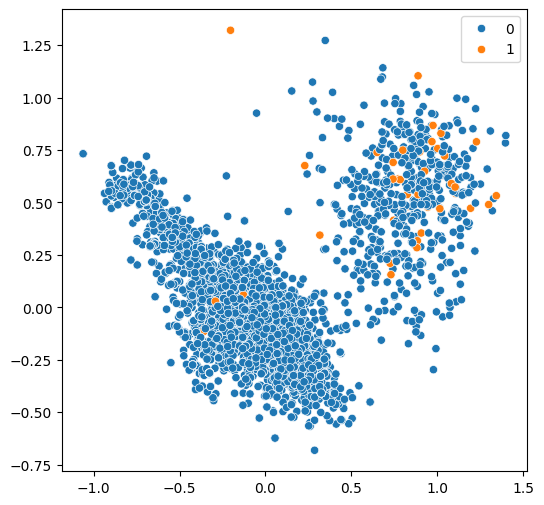

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

train_features = PCA(n_components=5).fit_transform(train_features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=train_features[:, 0], y=train_features[:, 1], hue=train_labels, palette="tab10")

<Axes: >

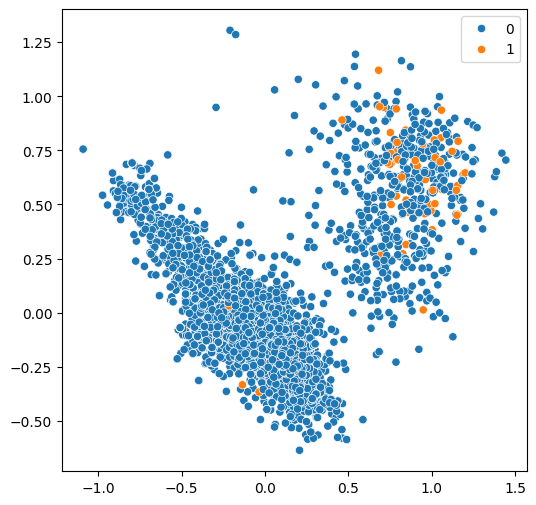

In [36]:

test_features = PCA(n_components=5).fit_transform(test_features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=test_features[:, 0], y=test_features[:, 1], hue=test_labels, palette="tab10")

In [37]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

In [38]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.99


In [39]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Assuming `svc` is your trained classifier
# Assuming `train_features` and `test_features` are your feature sets
# Assuming `train_labels` and `test_labels` are your true labels

# Get the predicted probabilities for each class
train_probs = svc.decision_function(train_features)
test_probs = svc.decision_function(test_features)

# Calculate AUROC
train_auroc = roc_auc_score(train_labels, train_probs)
test_auroc = roc_auc_score(test_labels, test_probs)

# Calculate AUPRC
train_auprc = average_precision_score(train_labels, train_probs)
test_auprc = average_precision_score(test_labels, test_probs)

print(f"Classical SVC AUROC on the training dataset: {train_auroc:.2f}")
print(f"Classical SVC AUROC on the test dataset:     {test_auroc:.2f}")

print(f"Classical SVC AUPRC on the training dataset: {train_auprc:.2f}")
print(f"Classical SVC AUPRC on the test dataset:     {test_auprc:.2f}")


Classical SVC AUROC on the training dataset: 0.88
Classical SVC AUROC on the test dataset:     0.42
Classical SVC AUPRC on the training dataset: 0.43
Classical SVC AUPRC on the test dataset:     0.01


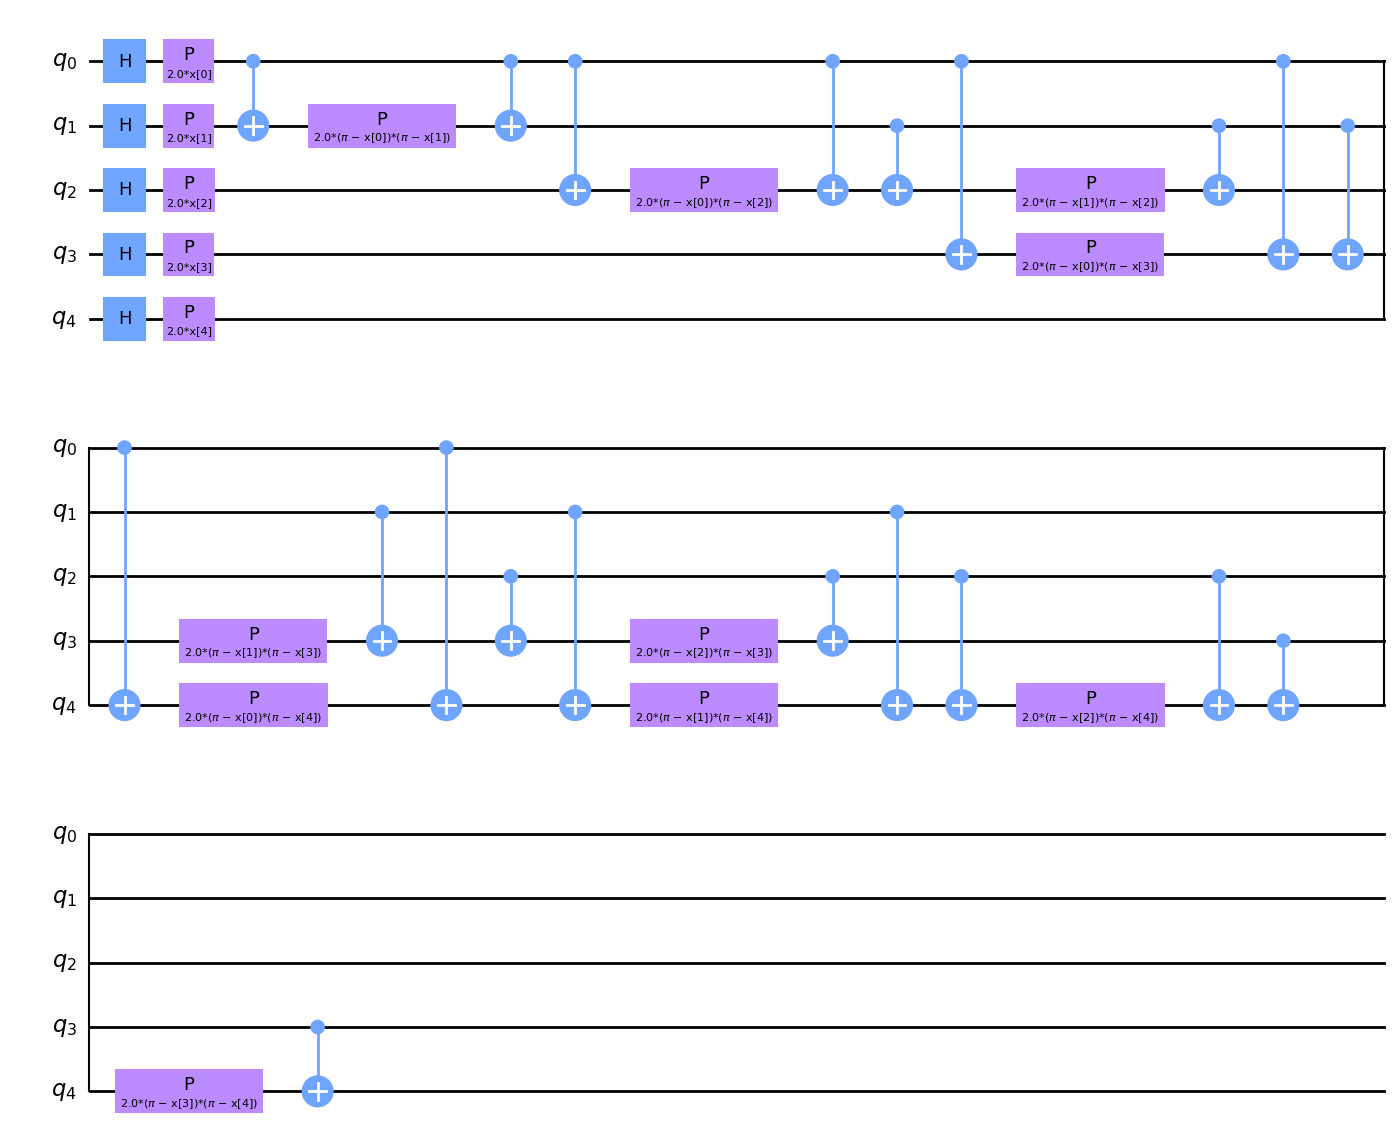

In [40]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)




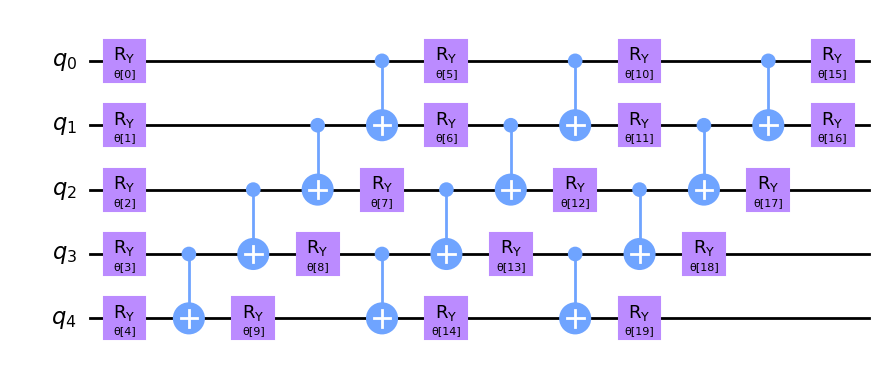

In [41]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [42]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=60)

In [43]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [44]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
!pip install qiskit-machine-learning

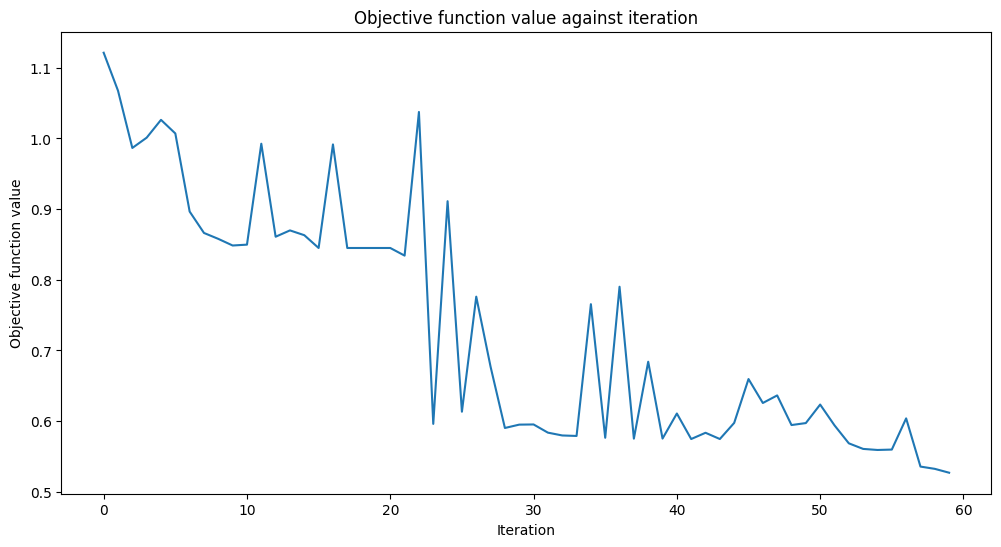

Training time: 2210 seconds


In [45]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [46]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.88
Quantum VQC on the test dataset:     0.89


In [47]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Assuming `vqc` is your trained VQC classifier
# Assuming `train_features` and `test_features` are your feature sets
# Assuming `train_labels` and `test_labels` are your true labels

# Get the raw predictions from the VQC model
train_raw_preds = vqc.predict(train_features)
test_raw_preds = vqc.predict(test_features)

# For binary classification, use the raw predictions as probabilities of the positive class
train_probs_positive_class = train_raw_preds
test_probs_positive_class = test_raw_preds

# Calculate AUROC
train_auroc = roc_auc_score(train_labels, train_probs_positive_class)
test_auroc = roc_auc_score(test_labels, test_probs_positive_class)

# Calculate AUPRC
train_auprc = average_precision_score(train_labels, train_probs_positive_class)
test_auprc = average_precision_score(test_labels, test_probs_positive_class)

print(f"VQC AUROC on the training dataset: {train_auroc:.2f}")
print(f"VQC AUROC on the test dataset:     {test_auroc:.2f}")

print(f"VQC AUPRC on the training dataset: {train_auprc:.2f}")
print(f"VQC AUPRC on the test dataset:     {test_auprc:.2f}")



VQC AUROC on the training dataset: 0.61
VQC AUROC on the test dataset:     0.74
VQC AUPRC on the training dataset: 0.02
VQC AUPRC on the test dataset:     0.05
